In [79]:
%run header.py data/ASIC-2-FPGA

Python version: 3.6.1 |Anaconda 4.4.0 (64-bit)| (default, May 11 2017, 13:25:24) [MSC v.1900 64 bit (AMD64)]
pandas version: 0.20.1
matplotlib version: 2.0.2
NumPy version: 1.14.1
SciPy version: 1.0.0
IPython version: 5.3.0
scikit-learn version: 0.19.1
-------------------------


In [2]:
df = df_dict['adpcm_encoder'].copy()
df.head(2)

,AREA,state,FU,REG,MUX,DEC,pin_pair,net,max,min,ave,MISC,MEM,sim,Pmax,Pmin,Pave,Latency,BlockMemoryBit,DSP,Slices,PF_ASIC,PF_FPGA,WithTolerance,WithToleranceL
0,1846,4,977,636,203,0,3246,1505,4,4,4.0,30,0,0,0,0,0,21,0,0,394,False,False,False,False
1,1574,4,670,636,238,0,2935,1337,4,4,4.0,30,0,0,0,0,0,21,0,0,356,False,True,False,False


# Scaling the valid features

In [4]:
df_scaled_dict = dict()
for benchmark in benchmarks:
    df_scaled = df_dict[benchmark].copy()
    df_scaled[valid_features] = StandardScaler().fit_transform(df_dict[benchmark][valid_features])
    df_scaled_dict[benchmark] = df_scaled

In [5]:
df_scaled_dict['adpcm_encoder'].head(2)

,AREA,state,FU,REG,MUX,DEC,pin_pair,net,max,min,ave,MISC,MEM,sim,Pmax,Pmin,Pave,Latency,BlockMemoryBit,DSP,Slices,PF_ASIC,PF_FPGA,WithTolerance,WithToleranceL
0,1846,0.1481,-0.5262,0.3926,-1.5082,0.0,-0.7903,-0.7649,0.1481,0.1481,0.1481,0.037,0.0,0.0,0.0,0.0,0.0,21,0.0,0.0,394,False,False,False,False
1,1574,0.1481,-0.7906,0.3926,-1.3040,0.0,-0.9001,-0.8888,0.1481,0.1481,0.1481,0.037,0.0,0.0,0.0,0.0,0.0,21,0.0,0.0,356,False,True,False,False


# Observe the feature selection results

In [80]:
fs_dict = dict()
for benchmark in benchmarks:
    df = df_dict[benchmark]
    df_scaled = df_scaled_dict[benchmark]
    
    X = df[valid_features].copy()
    X_scaled = df_scaled[valid_features].copy()
    y = df.AREA.astype(float)

    n_features, rank, fi = feature_ranking(X_scaled, y, kind='mutual_info')
    
    fs_dict[benchmark] = (n_features, rank, fi)
    
    print(benchmark, n_features)
    print(rank)
    print()

adpcm_encoder 3
['pin_pair' 'net' 'MUX' 'FU' 'MISC' 'REG' 'state' 'max' 'min' 'ave' 'Pave'
 'MEM' 'DSP' 'Pmin' 'DEC' 'BlockMemoryBit' 'sim' 'Pmax']

aes 2
['net' 'MUX' 'pin_pair' 'FU' 'MISC' 'REG' 'DEC' 'DSP' 'max' 'min'
 'BlockMemoryBit' 'ave' 'MEM' 'sim' 'Pmax' 'Pmin' 'Pave' 'state']

ann 4
['pin_pair' 'net' 'MUX' 'REG' 'MISC' 'max' 'ave' 'min' 'state' 'DEC' 'FU'
 'MEM' 'Pmax' 'Pave' 'BlockMemoryBit' 'sim' 'Pmin' 'DSP']

average 3
['net' 'pin_pair' 'MUX' 'MISC' 'REG' 'FU' 'ave' 'max' 'min' 'state' 'DEC'
 'Pmax' 'Pave' 'BlockMemoryBit' 'MEM' 'sim' 'Pmin' 'DSP']

decimation 7
['net' 'pin_pair' 'FU' 'MUX' 'REG' 'MISC' 'DSP' 'Pave' 'Pmin' 'Pmax' 'sim'
 'MEM' 'BlockMemoryBit' 'min' 'DEC' 'max' 'ave' 'state']

fft_fixed 9
['net' 'MUX' 'pin_pair' 'REG' 'MISC' 'FU' 'ave' 'min' 'max' 'state' 'DEC'
 'BlockMemoryBit' 'DSP' 'MEM' 'Pmin' 'sim' 'Pmax' 'Pave']

fir 8
['net' 'pin_pair' 'MUX' 'REG' 'MISC' 'ave' 'max' 'min' 'FU' 'state' 'Pmin'
 'DEC' 'Pmax' 'MEM' 'BlockMemoryBit' 'sim' 'Pave' 'DSP']



In [90]:
ref = np.argsort(fs_dict['snow3g'][2])
for benchmark in benchmarks:
    cand = np.argsort(fs_dict[benchmark][2])
    print('{}: {:.4f}'.format(benchmark, np.corrcoef(ref, cand)[0][1]))

adpcm_encoder: 0.5108
aes: 0.2921
ann: 0.8803
average: 0.6945
decimation: -0.0588
fft_fixed: 0.8369
fir: 0.6429
idct: 0.6863
interpolation: 0.7812
kasumi: 0.6450
qsort: 0.8080
snow3g: 1.0000
sobel: 0.7915


In [70]:
# benchmark_train = 'decimation'
# benchmark_test = 'adpcm_encoder'
adrs_mat = pd.DataFrame(0, index=benchmarks, columns=benchmarks)
hypervolume_mat = pd.DataFrame(0, index=benchmarks, columns=benchmarks)
dominance_mat = pd.DataFrame(0, index=benchmarks, columns=benchmarks)
all_mat = pd.DataFrame(0, index=benchmarks, columns=benchmarks)

for benchmark_train in benchmarks:
    for benchmark_test in benchmarks:
        # select features based on the testing bench
        n_predictors, predictor_rank = fs_dict[benchmark_test]
        predictors = predictor_rank[:n_predictors]

        # choose an estimator
        estimator = linear_model.LinearRegression()

        # prepare X and y
        df_train = df_scaled_dict[benchmark_train].copy()
        X = df_train[predictors].copy()
        y = df_train.Slices

        # training
        estimator.fit(X, y)

        # testing data set
        df_test = df_scaled_dict[benchmark_test].copy()
        X_test = df_test[predictors].copy()

        # prediction
        y_pred = estimator.predict(X_test)

        # get results
        df_test['AREA'] = y_pred
        dm = DirectMapping()
        dm.main(df_test)
        
        # check results
        adrs_bool = dm.results_no_tol['adrs_ave'] <= dm_v4_indexed.loc[benchmark_test, 'adrs_ave']
        hypervolume_bool = dm.results_no_tol['hypervolume'] >= dm_v4_indexed.loc[benchmark_test, 'hypervolume']
        dominance_bool = dm.results_no_tol['dominance'] >= dm_v4_indexed.loc[benchmark_test, 'dominance']
        
        # write results to matrix
        adrs_mat.loc[benchmark_train, benchmark_test] = int(adrs_bool)        
        hypervolume_mat.loc[benchmark_train, benchmark_test] = int(hypervolume_bool)
        dominance_mat.loc[benchmark_train, benchmark_test] = int(dominance_bool)
        all_mat.loc[benchmark_train, benchmark_test] = int(adrs_bool and hypervolume_bool and dominance_bool)

In [71]:
adrs_mat

,adpcm_encoder,aes,ann,average,decimation,fft_fixed,fir,idct,interpolation,kasumi,qsort,snow3g,sobel
adpcm_encoder,1,1,1,1,1,0,1,1,0,0,1,0,1
aes,0,1,0,1,0,1,1,1,1,1,1,0,1
ann,0,0,0,1,1,0,1,1,0,0,1,0,1
average,0,0,0,1,1,0,0,1,0,1,1,0,1
decimation,1,0,0,1,1,0,0,1,0,1,0,0,1
fft_fixed,0,0,0,1,1,1,1,1,0,1,1,0,1
fir,0,0,0,1,1,0,1,1,0,1,1,0,1
idct,0,1,1,1,0,0,0,1,1,1,0,0,1
interpolation,0,0,1,1,1,1,1,1,1,1,1,0,1
kasumi,0,0,1,1,0,1,0,1,1,1,1,0,1


In [73]:
hypervolume_mat

,adpcm_encoder,aes,ann,average,decimation,fft_fixed,fir,idct,interpolation,kasumi,qsort,snow3g,sobel
adpcm_encoder,1,1,1,1,1,0,1,1,0,0,0,1,1
aes,0,1,0,1,0,1,1,1,0,1,1,0,1
ann,1,1,0,1,1,0,1,0,0,0,0,1,0
average,1,1,0,1,1,1,1,0,1,1,1,1,0
decimation,1,1,0,1,1,1,1,0,0,0,0,1,0
fft_fixed,0,1,0,0,1,1,0,0,1,1,0,1,1
fir,1,1,0,1,1,1,1,0,0,0,1,1,0
idct,1,1,0,1,0,1,1,1,0,0,0,1,0
interpolation,1,1,0,1,1,1,1,1,1,0,1,1,1
kasumi,1,1,0,1,1,1,1,1,0,1,0,1,1


In [74]:
dominance_mat

,adpcm_encoder,aes,ann,average,decimation,fft_fixed,fir,idct,interpolation,kasumi,qsort,snow3g,sobel
adpcm_encoder,1,1,0,1,1,1,1,1,1,0,0,0,1
aes,0,1,0,1,1,1,1,1,0,1,0,0,1
ann,0,1,0,1,1,1,1,1,1,0,0,0,1
average,0,1,0,1,1,1,0,1,0,1,0,0,1
decimation,1,1,0,1,1,1,0,1,1,1,0,0,1
fft_fixed,0,1,0,1,1,1,1,1,1,1,0,0,1
fir,0,1,0,1,1,1,1,1,1,1,1,0,1
idct,0,1,0,1,0,1,0,1,0,1,0,0,1
interpolation,0,1,0,1,1,1,1,1,1,1,0,0,1
kasumi,0,1,0,1,1,1,0,1,0,1,0,0,1


In [72]:
all_mat

,adpcm_encoder,aes,ann,average,decimation,fft_fixed,fir,idct,interpolation,kasumi,qsort,snow3g,sobel
adpcm_encoder,1,1,0,1,1,0,1,1,0,0,0,0,1
aes,0,1,0,1,0,1,1,1,0,1,0,0,1
ann,0,0,0,1,1,0,1,0,0,0,0,0,0
average,0,0,0,1,1,0,0,0,0,1,0,0,0
decimation,1,0,0,1,1,0,0,0,0,0,0,0,0
fft_fixed,0,0,0,0,1,1,0,0,0,1,0,0,1
fir,0,0,0,1,1,0,1,0,0,0,1,0,0
idct,0,1,0,1,0,0,0,1,0,0,0,0,0
interpolation,0,0,0,1,1,1,1,1,1,0,0,0,1
kasumi,0,0,0,1,0,1,0,1,0,1,0,0,1


In [63]:
dm.results_no_tol

{'adrs_ave': 0.0023521505376344087,
 'adrs_ave_rms': 0.0023521457571661322,
 'adrs_max': 0.014112903225806451,
 'adrs_max_rms': 0.014112874542996794,
 'cardinality': 6,
 'dominance': 0.8333333333333334,
 'hypervolume': 0.994304331436207}

In [67]:
dm_v4_indexed = dm_v4.set_index('benchmark')
dm_v4_indexed.loc[benchmark_test, 'adrs_ave']

0.0251

In [75]:
# benchmark_train = 'decimation'
# benchmark_test = 'adpcm_encoder'
adrs_mat = pd.DataFrame(0, index=benchmarks, columns=benchmarks)
hypervolume_mat = pd.DataFrame(0, index=benchmarks, columns=benchmarks)
dominance_mat = pd.DataFrame(0, index=benchmarks, columns=benchmarks)
all_mat = pd.DataFrame(0, index=benchmarks, columns=benchmarks)

for benchmark_train in benchmarks:
    for benchmark_test in benchmarks:
        # select features based on the testing bench
        n_predictors, predictor_rank = fs_dict[benchmark_test]
        predictors = predictor_rank[:n_predictors]

        # choose an estimator
        estimator = ensemble.RandomForestRegressor(random_state=42)

        # prepare X and y
        df_train = df_scaled_dict[benchmark_train].copy()
        X = df_train[predictors].copy()
        y = df_train.Slices

        # training
        estimator.fit(X, y)

        # testing data set
        df_test = df_scaled_dict[benchmark_test].copy()
        X_test = df_test[predictors].copy()

        # prediction
        y_pred = estimator.predict(X_test)

        # get results
        df_test['AREA'] = y_pred
        dm = DirectMapping()
        dm.main(df_test)
        
        # check results
        adrs_bool = dm.results_no_tol['adrs_ave'] <= dm_v4_indexed.loc[benchmark_test, 'adrs_ave']
        hypervolume_bool = dm.results_no_tol['hypervolume'] >= dm_v4_indexed.loc[benchmark_test, 'hypervolume']
        dominance_bool = dm.results_no_tol['dominance'] >= dm_v4_indexed.loc[benchmark_test, 'dominance']
        
        # write results to matrix
        adrs_mat.loc[benchmark_train, benchmark_test] = int(adrs_bool)        
        hypervolume_mat.loc[benchmark_train, benchmark_test] = int(hypervolume_bool)
        dominance_mat.loc[benchmark_train, benchmark_test] = int(dominance_bool)
        all_mat.loc[benchmark_train, benchmark_test] = int(adrs_bool and hypervolume_bool and dominance_bool)

In [76]:
adrs_mat

,adpcm_encoder,aes,ann,average,decimation,fft_fixed,fir,idct,interpolation,kasumi,qsort,snow3g,sobel
adpcm_encoder,1,0,0,1,1,0,1,1,0,1,1,1,1
aes,0,1,0,1,1,0,1,1,1,1,1,1,1
ann,0,0,1,1,1,0,0,1,0,1,1,0,1
average,1,0,0,1,1,1,1,1,1,1,0,1,1
decimation,0,0,0,1,1,0,1,1,1,1,1,1,1
fft_fixed,0,0,0,1,1,1,0,1,0,1,1,1,1
fir,0,0,0,1,1,0,1,1,1,1,1,1,1
idct,1,0,0,1,1,0,1,1,0,0,1,1,1
interpolation,0,0,0,1,1,1,0,1,1,1,1,1,1
kasumi,0,0,0,1,1,1,0,1,1,1,0,0,1


In [77]:
all_mat

,adpcm_encoder,aes,ann,average,decimation,fft_fixed,fir,idct,interpolation,kasumi,qsort,snow3g,sobel
adpcm_encoder,1,0,0,1,1,0,0,1,0,0,0,1,1
aes,0,1,0,1,1,0,1,1,1,1,0,0,0
ann,0,0,1,1,1,0,0,1,0,1,0,0,1
average,1,0,0,1,1,0,1,1,1,1,0,1,0
decimation,0,0,0,1,1,0,1,1,1,0,0,1,1
fft_fixed,0,0,0,1,1,1,0,1,0,1,0,1,1
fir,0,0,0,1,1,0,1,1,0,1,0,1,0
idct,1,0,0,1,1,0,1,1,0,0,0,1,1
interpolation,0,0,0,1,1,1,0,0,1,0,0,1,0
kasumi,0,0,0,0,1,1,0,1,1,1,0,0,0


In [ ]:
def orthogonal_projection(v, line):
    line_unit = preprocessing.normalize(line)
    cp = np.dot(v, line_unit[1])/np.dot(line_unit[1], line_unit[1])
    v_projected = []
    for i in cp:
        v_projected.append(i * line_unit[1, :])
    v_projected = np.array(v_projected)
    
    plt.figure(figsize=(8, 8))
    plt.scatter(v[:, 0], v[:, 1])
    plt.plot(line[:, 0], line[:, 1])
    plt.plot(line_unit[:, 0], line_unit[:, 1])
    plt.scatter(v_projected[:, 0], v_projected[:, 1])
#     plt.axis('equal')
    plt.show()
    
    return cp

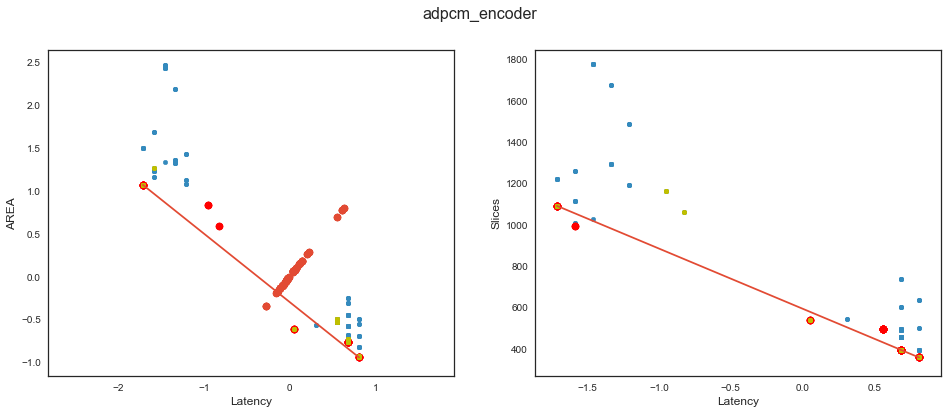

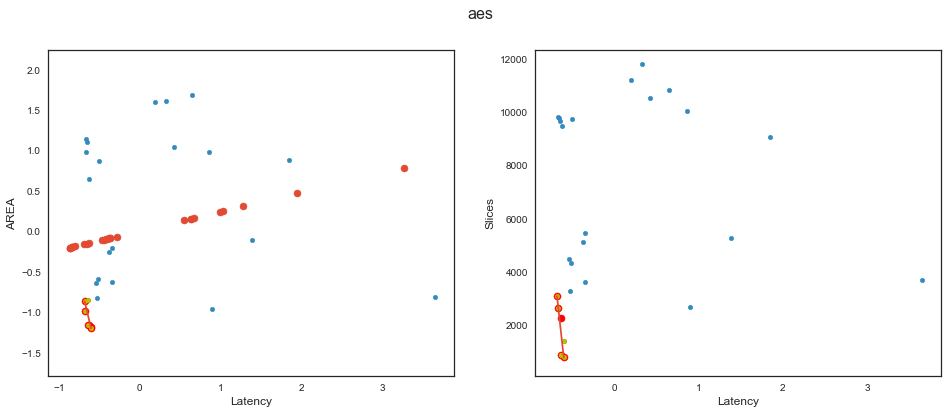

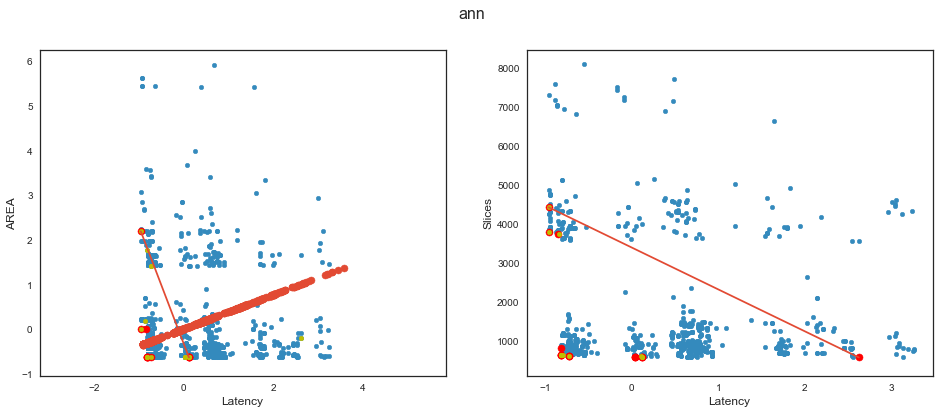

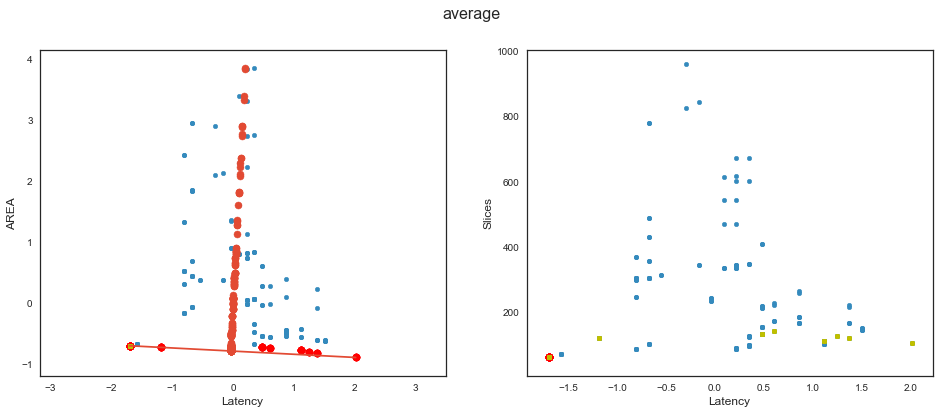

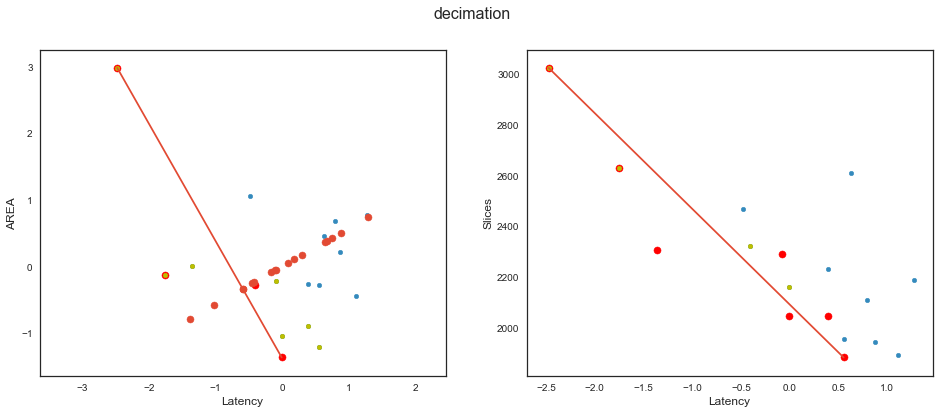

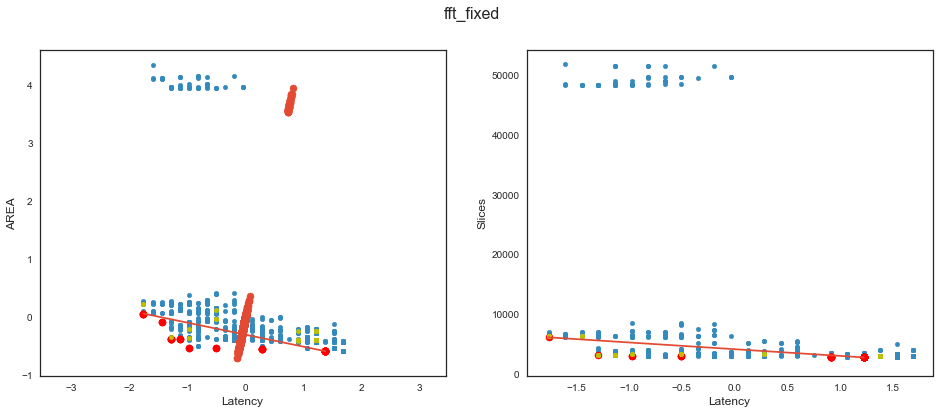

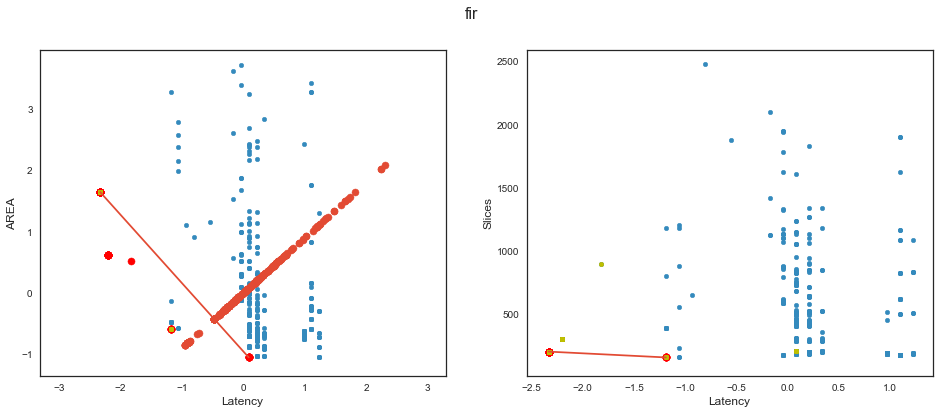

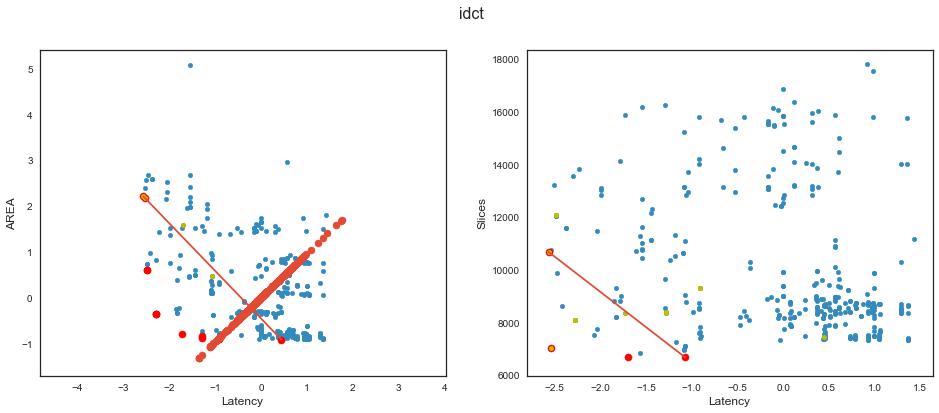

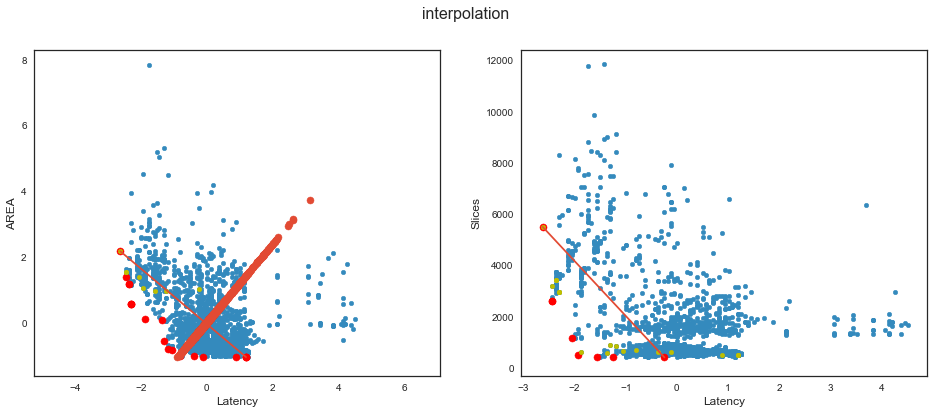

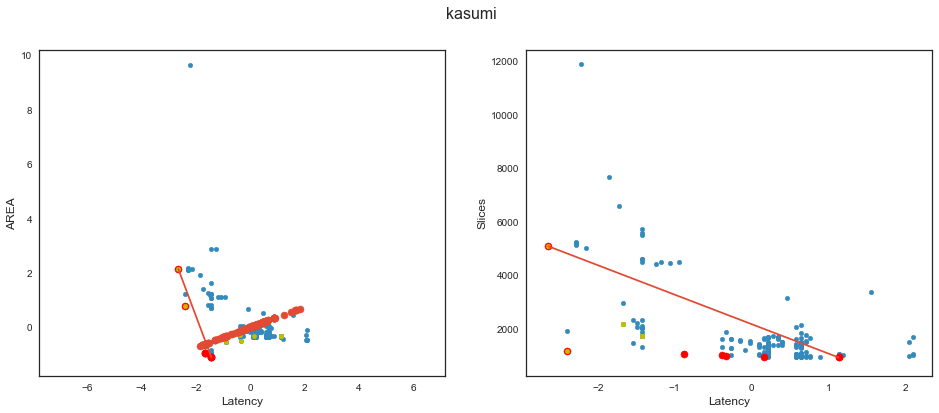

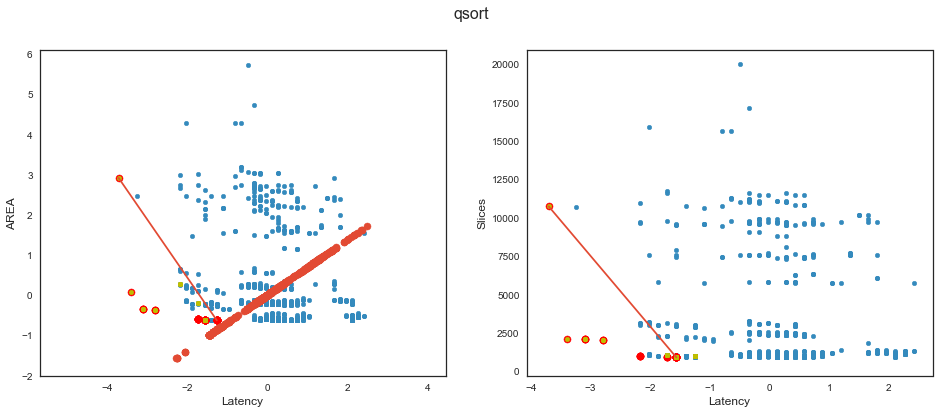

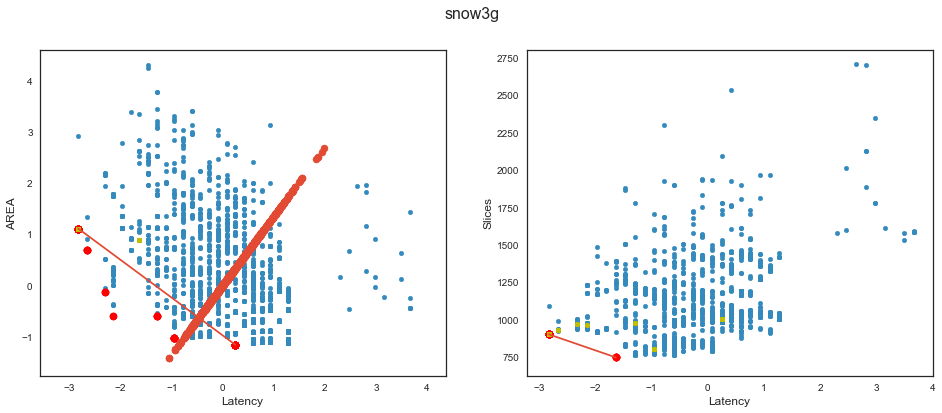

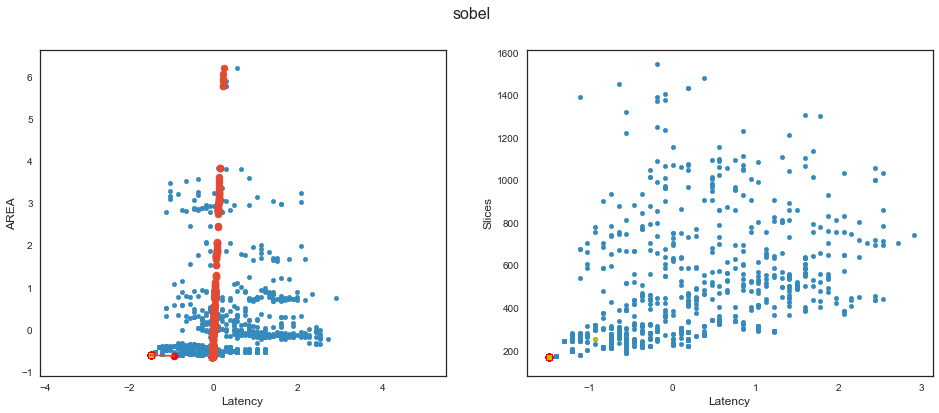

In [93]:
for benchmark in benchmarks:
    df_labeled = df_dict[benchmark]
    
    # scaling AREA and Latency
    df_tmp = df_labeled[['AREA', 'Latency']].copy()
    df_labeled[['AREA', 'Latency']] = StandardScaler().fit_transform(df_tmp)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    df_labeled.plot(kind='scatter', x='Latency', y='AREA', ax=axes[0])
    df_labeled[df_labeled.PF_ASIC].plot(kind='scatter', x='Latency', y='AREA', c='r', s=50, ax=axes[0])
    df_labeled[df_labeled.PF_FPGA].plot(kind='scatter', x='Latency', y='AREA', c='y', ax=axes[0])
    
    # draw a line acrossing the smallest and the biggest Pareto optimal
    pf = df_labeled.loc[df_labeled.PF_ASIC, ['Latency', 'AREA']].as_matrix()
    pf_ends = pf[np.argsort(pf[:, 0])][[0, -1], :]
    axes[0].plot(pf_ends[:, 0], pf_ends[:, 1])
    
    # orthogonal projection
    pf_ends[1, :] = 0 - pf_ends[1, :]
    pfs = pf_ends.sum(axis=0)
    if pfs[1] == 0:
        continue
    else:
        slope = pfs[0] / pfs[1]
        slope = -slope
        line = np.array([[0, 0], [1, slope]])
        v = df_labeled[['Latency', 'AREA']].as_matrix()
        
        line_unit = preprocessing.normalize(line)
        cp = np.dot(v, line_unit[1])/np.dot(line_unit[1], line_unit[1])
        v_projected = []
        for i in cp:
            v_projected.append(i * line_unit[1, :])
        v_projected = np.array(v_projected)
        axes[0].scatter(v_projected[:, 0], v_projected[:, 1])
        axes[0].axis('equal')
        
    
    df_labeled.plot(kind='scatter', x='Latency', y='Slices', ax=axes[1])
    df_labeled[df_labeled.PF_FPGA].plot(kind='scatter', x='Latency', y='Slices', c='r', s=50, ax=axes[1])
    df_labeled[df_labeled.PF_ASIC].plot(kind='scatter', x='Latency', y='Slices', c='y', ax=axes[1])
    # draw a line acrossing the smallest and the biggest Pareto optimal
    pf = df_labeled.loc[df_labeled.PF_FPGA, ['Latency', 'Slices']].as_matrix()
    pf_ends = pf[np.argsort(pf[:, 0])][[0, -1], :]
    axes[1].plot(pf_ends[:, 0], pf_ends[:, 1])
    
    fig.suptitle(benchmark, fontsize=16)
    plt.show()